# 因子回测

## 导入模块

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker
from scipy import stats
import feather
import os
import statsmodels.api as sm
import sunlandsdatasdk as sd

## 读入日线数据

### 读入日线数据

In [2]:
price_1d = feather.read_dataframe('../data/StockPriceK1d_20241231.feather')

### 计算调仓日

In [3]:
trade_date = price_1d['date'].sort_values().unique()
start_date = '2019-01-01'
end_date = '2025-01-01'
mes = pd.date_range(start=start_date, end=end_date, freq='1ME')
adj_date = np.array([], dtype=np.datetime64)
for me in mes:
    trade_date_before = trade_date[trade_date <= me]
    ad = trade_date_before[-1]
    adj_date = np.append(adj_date, ad)
map_mon_adj = {ad.year * 100 + ad.month: ad for ad in adj_date}

### 计算每两个调仓日之间的收益

In [4]:
price_1d['year_mon'] = price_1d['date'].dt.year * 100 + price_1d['date'].dt.month

def ret_acc_prod(price_1d):
    ret = price_1d['ret']
    return (1 + ret).prod() - 1

def ret_acc(price_1d):
    preclose = price_1d.iloc[0]['preclose']
    close = price_1d.iloc[-1]['close']
    return (close - preclose) / preclose

def ret_acc_adj(price_1d):
    hfq = price_1d['close'] * price_1d['adj']
    return hfq / hfq.shift(1) - 1

# price_prod = (
#     price_1d[(price_1d['date'] >= start_date) & (price_1d['date'] <= end_date)]
#         .groupby(['issue', 'year_mon'])[['preclose', 'close', 'adj', 'ret']]
#         .apply(ret_acc_prod)
#         .reset_index()
# )

mon_last = (
    price_1d[(price_1d['date'] >= '2018-12-01') & (price_1d['date'] <= end_date)]
        .groupby(['issue', 'year_mon'])
        .last()
)
price_adj = (
    mon_last
        .groupby('issue', group_keys=False)
        .apply(ret_acc_adj)
        .reset_index()
        .dropna()
)

price_adj = price_adj.rename(columns={0: 'ret'})
price_adj['date'] = price_adj['year_mon'].apply(map_mon_adj.get)
price_adj['ret_next'] = price_adj.groupby('issue')['ret'].shift(-1)
price_adj = price_adj[['issue', 'date', 'ret', 'ret_next']]
price_adj = price_adj.dropna(subset='ret_next')

### 剔除股票

In [5]:
def newly_listed(date, timedelta='180D'):
    start_date = date.min()
    newly = (date <= start_date + pd.Timedelta(timedelta))
    return newly

price_1d['newly_listed'] = (
    price_1d
        .groupby('issue')['date']
        .transform(newly_listed)
)

price_adj = pd.merge(
    price_adj,
    price_1d[['issue', 'date', 'newly_listed', 'is_limit_sell', 'is_limit_buy']],
    on=['issue', 'date'],
    how='left'
)

price_adj = price_adj[
    (~price_adj['newly_listed']) &
    (~price_adj['is_limit_buy'].astype(bool)) &
    (~price_adj['is_limit_sell'].astype(bool))
]
price_adj = price_adj[['issue', 'date', 'ret', 'ret_next']]

## 计算基准

### 中证 500

In [44]:
# sd.auth('*', '*')
# index_bar = sd.get_index_bar('000906', start_date='2018-12-01', end_date=end_date)
# index_bar['date'] = pd.to_datetime(index_bar['date'])
# index_bar = index_bar.drop(columns='_id')

# index_bar['year_mon'] = index_bar['date'].dt.year * 100 + index_bar['date'].dt.month
# index_bar = index_bar.groupby('year_mon').last()
# ret_index = index_bar['close'] / index_bar['close'].shift(1) - 1
# ret_index = ret_index.reset_index().dropna().rename(columns={'close': 'ret'})
# ret_index['date'] = ret_index['year_mon'].apply(map_mon_adj.get)
# ret_index['ret_next'] = ret_index['ret'].shift(-1)
# ret_index = ret_index.dropna()

# os.makedirs('../data/benchmark/', exist_ok=True)
# feather.write_dataframe(ret_index, '../data/benchmark/benchmark_000906.feather')

### 全样本等权

In [54]:
# ret_sample = (
#     price_adj
#         .groupby('date')[['ret', 'ret_next']]
#         .mean().reset_index()
# )
# os.makedirs('../data/benchmark/', exist_ok=True)
# feather.write_dataframe(ret_mean, '../data/benchmark/benchmark_sample.feather')

## IC 测试

In [6]:
def IC_calc_once(factor, factor_col, ret_col):
    IC, p = stats.spearmanr(factor[factor_col], factor[ret_col])
    return IC

def IC_calc(factor, factor_col):
    f = factor.copy()
    f = pd.merge(
        f,
        price_adj,
        on=['issue', 'date'],
        how='inner'
    )  
    IC = (
        f
            .groupby('date')[[factor_col, 'ret_next']]
            .apply(IC_calc_once, factor_col=factor_col, ret_col='ret_next')
    )
    return IC

## 分组测试

In [7]:
def grouped_ret(f, factor_col):
    f_date = f.copy()
    qcut = pd.qcut(
        f_date[factor_col],
        q=10,
        labels=np.arange(1, 11)
    )
    f_date['group'] = qcut
    ret = f_date.groupby('group', observed=False)['ret_next'].mean()
    return ret

def grouped_calc(factor, factor_col, factor_name=None, dirname=None):
    if factor_name == None:
        factor_name = factor_col
    f = pd.merge(
        factor,
        price_adj,
        on=['issue', 'date'],
        how='inner'
    )
    ret = (
        f
            .groupby('date')[[factor_col, 'ret', 'ret_next']]
            .apply(grouped_ret, factor_col=factor_col)
    )
    
    ret_annual = (1 + ret.mean()) ** 12 - 1
    # ret_annual = (1 + ret).prod() ** (12 / len(ret)) - 1
    plt.bar(ret_annual.index, ret_annual, color='#a60021')
    plt.xlabel('Group')
    plt.ylabel('Annualized Return')
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
    if dirname == None:
        plt.show()
    else:
        os.makedirs(dirname, exist_ok=True)
        plt.savefig(dirname + '/grouped_' + factor_name + '.png')
        plt.close()
    
    long = (1 + ret[10]).cumprod()
    long_short = (1 + ret[10] - ret[1]).cumprod()
    plt.plot(long, linewidth=3, color='#a60021', label='long')
    plt.plot(long_short, linewidth=3, color='#ffc000', label='long-short')
    plt.legend()
    plt.grid()
    plt.xlabel('Time')
    plt.ylabel('Net Value')
    if dirname == None:
        plt.show()
    else:
        os.makedirs(dirname, exist_ok=True)
        plt.savefig(dirname + '/nv_' + factor_name + '.png')
        plt.close()

    return ret

## 一键回测

In [8]:
def backtest(filename, factor_col, factor_name=None, dirname=None):
    if factor_name == None:
        factor_name = factor_col
    factor = feather.read_dataframe(filename)

    df_IC = pd.DataFrame(columns=['factor', 'IC_mean', 'IC_IR', 't', "max", 'min'])
    IC = IC_calc(factor, factor_col=factor_col)
    df_IC.loc[0] = [
        factor_name,
        IC.mean(),
        IC.mean() / IC.std(),
        np.sqrt(len(IC)) * IC.mean() / IC.std(),
        IC.max(),
        IC.min()
    ]

    sign = np.sign(IC.mean())
    factor[factor_col] *= sign

    df_grouped = pd.DataFrame(columns=['factor', 'long_annual', 'long_sharpe', 'long_short_annual'])
    grouped = grouped_calc(
        factor, factor_col=factor_col,
        factor_name=factor_name, dirname=dirname
    )
    mean_annual = (1 + grouped[10].mean()) ** 12 - 1
    std_annual = np.sqrt(12) * grouped[10].std()
    long_short = (1 + (grouped[10] - grouped[1]).mean()) ** 12 - 1
    df_grouped.loc[0]=[
        factor_name,
        mean_annual,
        mean_annual / std_annual,
        long_short
    ]

    return df_IC, df_grouped

## 跳跃收益因子回测

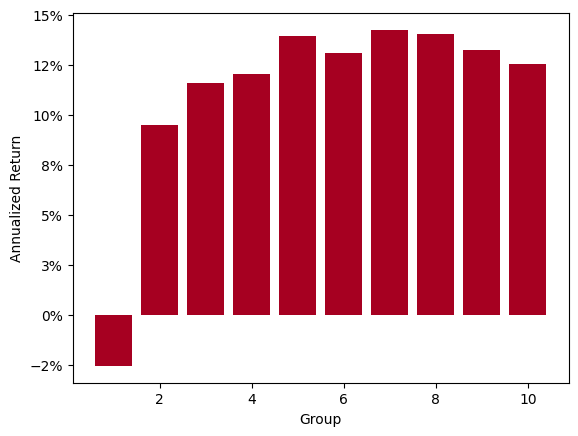

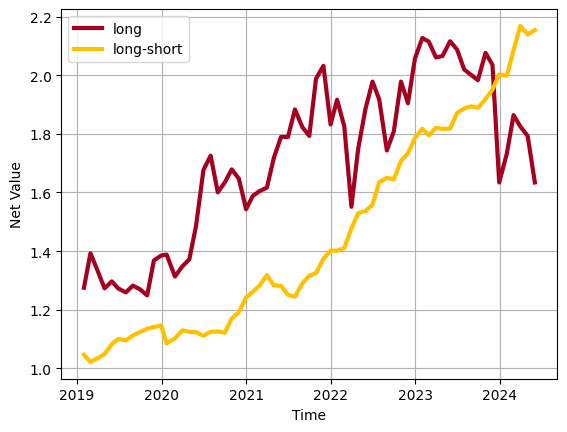

----------ret_jump_neutral----------


,factor,IC_mean,IC_IR,t,max,min
0,ret_jump_neutral,-0.044754,-0.908022,-7.320704,0.071218,-0.170906


,factor,long_annual,long_sharpe,long_short_annual
0,ret_jump_neutral,0.125589,0.523905,0.154791


In [9]:
# cols = ['ret_jump', 'indus_factor', 'neutral_factor']
# names = ['ret_jump', 'ret_jump_indus', 'ret_jump_neutral']
cols = ['neutral_factor']
names = ['ret_jump_neutral']
for factor_col, factor_name in zip(cols, names):
    IC, grouped = backtest(
        '../data/ret_jump/neutral_ret_jump.feather',
        factor_col=factor_col,
        factor_name=factor_name,
        # dirname='../data/ret_jump/backtest1/'
    )
    print('-' * 10 + factor_name + '-' * 10)
    display(IC)
    display(grouped)

## 点度中心性回测

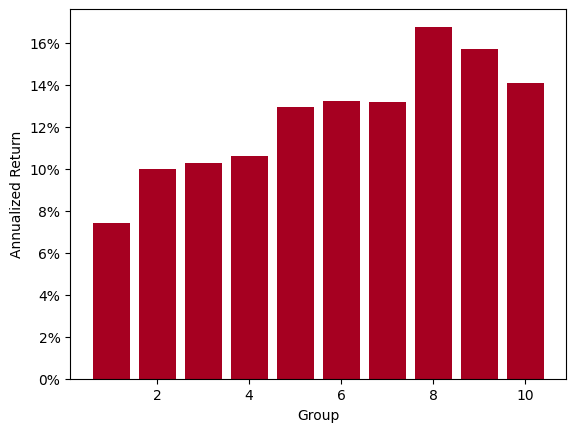

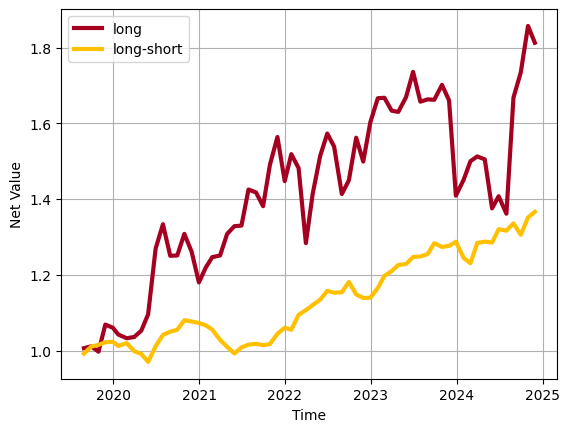

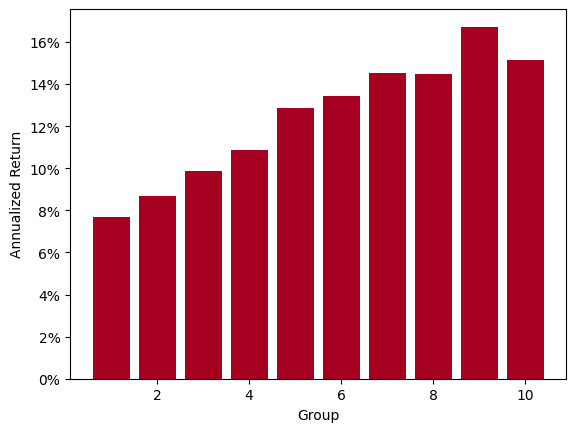

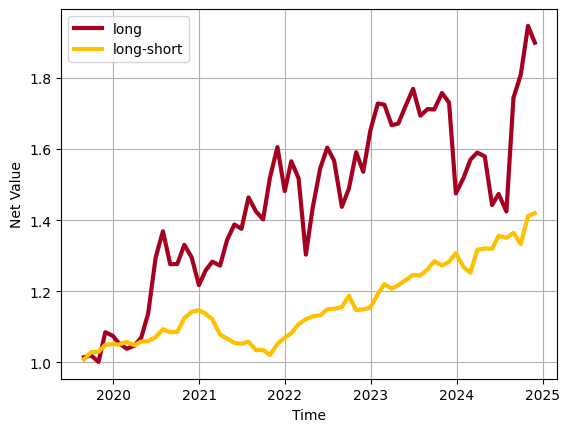

,factor,IC_mean,IC_IR,t,max,min
0,num_neutral,0.032458,0.687543,5.500341,0.132384,-0.113138
0,size_neutral,0.034445,0.703264,5.626112,0.139135,-0.109252


,factor,long_annual,long_sharpe,long_short_annual
0,num_neutral,0.140702,0.686683,0.062071
0,size_neutral,0.151315,0.730066,0.069828


In [10]:
dirname = '../data/N_connect_0_1/'
filename_num = dirname + '/neutral_N_connect_num.feather'
filename_size = dirname + '/neutral_N_connect_size.feather'
# cols = ['N_connect', 'indus_factor', 'neutral_factor']
# names_num = ['num', 'num_indus', 'num_neutral']
# names_size = ['size', 'size_indus', 'size_neutral']
cols=['neutral_factor']
names_num = ['num_neutral']
names_size = ['size_neutral']
for col, name_num, name_size in zip(cols, names_num, names_size):
    IC_num, grouped_num = backtest(filename_num, col, name_num)#, dirname + '/backtest1/')
    IC_size, grouped_size = backtest(filename_size, col, name_size)#, dirname + '/backtest1/')
    IC = pd.concat([IC_num, IC_size])
    grouped = pd.concat([grouped_num, grouped_size])
    display(IC)
    display(grouped)

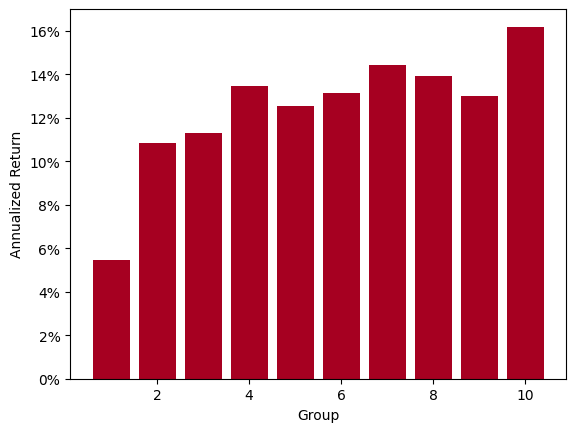

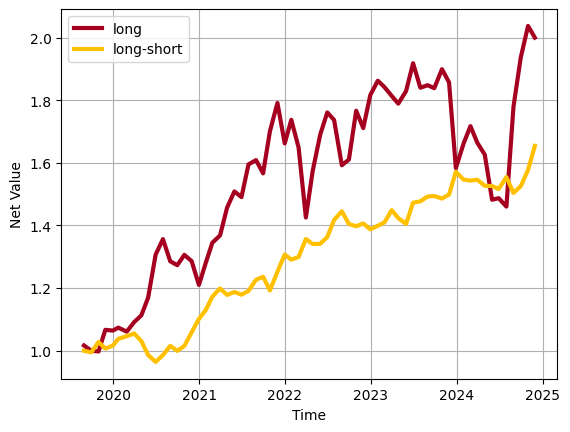

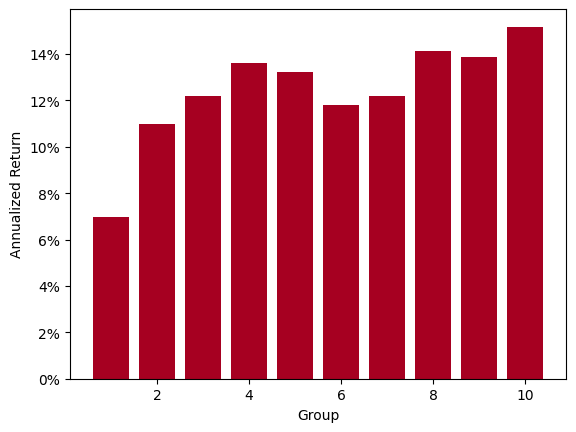

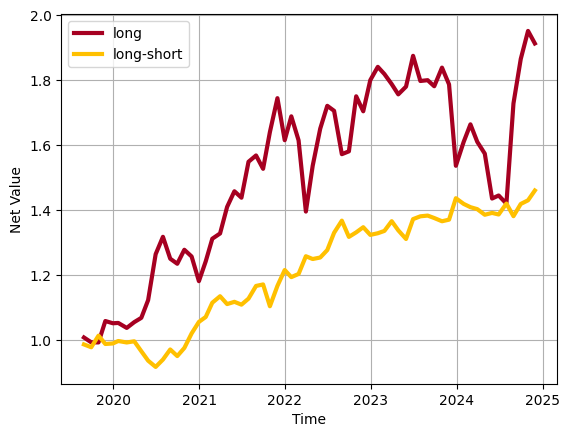

,factor,IC_mean,IC_IR,t,max,min
0,num_neutral,-0.035211,-0.443922,-3.551374,0.117998,-0.225968
0,size_neutral,-0.030819,-0.387398,-3.099182,0.128809,-0.194819


,factor,long_annual,long_sharpe,long_short_annual
0,num_neutral,0.161898,0.793566,0.102448
0,size_neutral,0.151779,0.750119,0.077359


In [11]:
dirname = '../data/N_connect_1_any/'
filename_num = dirname + '/neutral_N_connect_num.feather'
filename_size = dirname + '/neutral_N_connect_size.feather'
# cols = ['N_connect', 'indus_factor', 'neutral_factor']
# names_num = ['num', 'num_indus', 'num_neutral']
# names_size = ['size', 'size_indus', 'size_neutral']
cols=['neutral_factor']
names_num = ['num_neutral']
names_size = ['size_neutral']
for col, name_num, name_size in zip(cols, names_num, names_size):
    IC_num, grouped_num = backtest(filename_num, col, name_num)#, dirname + '/backtest1/')
    IC_size, grouped_size = backtest(filename_size, col, name_size)#, dirname + '/backtest1/')
    IC = pd.concat([IC_num, IC_size])
    grouped = pd.concat([grouped_num, grouped_size])
    display(IC)
    display(grouped)

## 跳跃关联动量因子回测

In [12]:
# filename_num = '../data/peer_ret/neutral_peer_ret_num.feather'
# filename_size = '../data/peer_ret/neutral_peer_ret_size.feather'
# IC_num, grouped_num = backtest(filename_num, 'neutral_factor', 'peer_relative_ret_num')
# IC_size, grouped_size = backtest(filename_size, 'neutral_factor', 'peer_relative_ret_size')
# IC = pd.concat([IC_num, IC_size])
# grouped = pd.concat([grouped_num, grouped_size])
# display(IC)
# display(grouped)